# **U.S. Regional Import Tariff Analysis (2023)**

This notebook analyzes U.S. import values and associated tariff rates by Census-defined regions (Midwest, Northeast, South, and West) using detailed port-level data from the **U.S. Census Bureau's International Trade API**.

## **Data Source**
All trade data is retrieved from the U.S. Census Bureau's API endpoint:  
📊 [`https://api.census.gov/data/timeseries/intltrade/imports/porths`](https://api.census.gov/data/timeseries/intltrade/imports/porths)

This dataset provides monthly records of imports to the United States by port, country of origin, and commodity, including:
- Port codes and names  
- Country codes and names  
- Monthly import values (`GEN_VAL_MO`)  
- Summary levels and classifications  

Tariff data is from 2 Apr 2025 White House annoucement (does not include pause), and  other sources are used for China, Mexico and Canada

## **How to Use**
1. Ensure you have a valid **Census API key** (register [here](https://api.census.gov/data/key_signup.html)).  
2. Set your API key in the script under `API_KEY = "YOUR_API_KEY"`.  
3. Run the notebook to fetch, clean, aggregate, and analyze the data.  
4. Outputs include total import values, weighted average tariffs, and regional trade shares.


In [25]:
#!pip install ace_tools

In [3]:
import requests
import pandas as pd
import plotly.express as px

# Replace with your actual Census API key
API_KEY = ""  # Placeholder, replace with actual key if running locally




## **Fresh Data Pull from U.S. Census API**

This section fetches the latest port-level import data from the U.S. Census Bureau's International Trade API for the year 2023.

The data is saved to a local CSV file to avoid repeated API calls—ideal for faster reruns and reproducible analysis.

> ⚠️ *Note: You’ll need a valid Census API key to run this section.*



In [3]:


def fetch_import_data_for_year(year='2023'):
    url = "https://api.census.gov/data/timeseries/intltrade/imports/porths"
    month = 1
    
    all_data = []
    for month in range(1, 13):
        params = {
        "get": "CTY_CODE,PORT,PORT_NAME,CTY_NAME,SUMMARY_LVL,GEN_VAL_MO",
        "YEAR": year,
        "MONTH": f"{month:02d}",
        # "COMM_LVL": "HS2",
        # "CTY_CODE": "ALL",
        "key": API_KEY
        }
        url = "https://api.census.gov/data/timeseries/intltrade/imports/porths/variables.json"
        response = requests.get(url, params=params)
        data = response.json()
        df = pd.DataFrame(data[1:], columns=data[0])
        df["MONTH"] = f"{month:02d}"
        df["YEAR"] = year
        all_data.append(df)
        
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    
    return pd.DataFrame()
        
      
    
df_initial = fetch_import_data_for_year()
df_initial
df_initial.to_csv('FullPortData.csv',index=False)

## **Data Organizing and Cleaning**

This section prepares the raw import data for analysis. It includes:

- Converting data types 
- Merging port codes with CBSA and U.S. Census regions
- Cleaning column formats (e.g., splitting city/state, trimming whitespace)
- Mapping country codes to names and ISO codes
- Filtering out incomplete or inconsistent records

The goal is to ensure the dataset is consistent, well-labeled, and ready for aggregation and analysis.

Note: 
- Port-to-CBSA cross-walk was established using the 'Port_to_CBSA.ipynb' - estimated using ChatGPT - Caution, there could be some errors here.
- Tariff rates are as announced on 2 Apr 2025, except for China, Mexico and Canada, which were estabishled through seperate annoucements.
    - China is at 145% (estimated to be 147.6% on trade-weighted from [Peterson](https://www.piie.com/research/piie-charts/2019/us-china-trade-war-tariffs-date-chart))
    - Mexico and Canada estimated trade-weighted tariff at 15.5% for Meixco and 11.9% for Canada by [Richmond Fed](https://www.richmondfed.org/publications/research/economic_brief/2025/eb_25-12)





In [64]:
df_initial = pd.read_csv('FullPortData.csv')

In [65]:
#df_initial.dtypes
df_all = df_initial
df_all["GEN_VAL_MO"] = pd.to_numeric(df_all["GEN_VAL_MO"], errors="coerce")


In [66]:
df_all = df_all.drop('Unnamed: 0',axis=1)

In [67]:
df_agg = df_all.groupby(["CTY_CODE", "CTY_NAME", "PORT", "PORT_NAME"])["GEN_VAL_MO"].sum().reset_index()
df_agg


,CTY_CODE,CTY_NAME,PORT,PORT_NAME,GEN_VAL_MO
0,-,TOTAL FOR ALL COUNTRIES,-,TOTAL FOR ALL PORTS,3080170295122
1,-,TOTAL FOR ALL COUNTRIES,0101,"PORTLAND, ME",3365516011
2,-,TOTAL FOR ALL COUNTRIES,0102,"BANGOR, ME",1446306337
3,-,TOTAL FOR ALL COUNTRIES,0103,"EASTPORT, ME",18862215
4,-,TOTAL FOR ALL COUNTRIES,0104,"JACKMAN, ME",505321323
...,...,...,...,...,...
21801,7XXX,AFRICA,5504,"OKLAHOMA CITY, OK",0
21802,7XXX,AFRICA,5506,"AUSTIN, TX",2946846
21803,7XXX,AFRICA,5507,"SAN ANTONIO, TX",5050
21804,7XXX,AFRICA,6000,VESSELS UNDER OWN POWER,191027


In [68]:
df_agg.loc[df_agg['PORT_NAME'] == 'CHICAGO EXECUTIVE AIRPORT, IL (FORMALLY PAL-WAUKEE', 'PORT_NAME'] = 'CHICAGO EXECUTIVE AIRPORT, IL'


In [69]:
df_tariffs = pd.read_csv('tariff_rate.csv')
df_tariffs["TARIFF"] = df_tariffs["TARIFF"].str.replace('%', '', regex=False).astype(float)


In [70]:
df_agg['CTY_NAME'].drop_duplicates().to_csv('country.csv', index=False)
df_agg[['PORT','PORT_NAME']].drop_duplicates().to_csv('port_names.csv', index=False)

In [71]:

# Assume df contains a column named PORT_NAME with values like "City, State"
# Split the PORT_NAME into CITY and STATE
# Safely split into city and state
split_port = df_agg['PORT_NAME'].str.split(',', n=1, expand=True)

# Handle cases with missing values
# df_agg['CITY'] = split_port[0].str.strip()
# df_agg['STATE'] = split_port[1].fillna('').str.strip()


split_port = df_agg['PORT_NAME'].str.rsplit(',', n=1, expand=True)
df_agg['CITY'] = split_port[0].str.strip()
df_agg['STATE'] = split_port[1].fillna('').str.strip()
df_agg

,CTY_CODE,CTY_NAME,PORT,PORT_NAME,GEN_VAL_MO,CITY,STATE
0,-,TOTAL FOR ALL COUNTRIES,-,TOTAL FOR ALL PORTS,3080170295122,TOTAL FOR ALL PORTS,
1,-,TOTAL FOR ALL COUNTRIES,0101,"PORTLAND, ME",3365516011,PORTLAND,ME
2,-,TOTAL FOR ALL COUNTRIES,0102,"BANGOR, ME",1446306337,BANGOR,ME
3,-,TOTAL FOR ALL COUNTRIES,0103,"EASTPORT, ME",18862215,EASTPORT,ME
4,-,TOTAL FOR ALL COUNTRIES,0104,"JACKMAN, ME",505321323,JACKMAN,ME
...,...,...,...,...,...,...,...
21801,7XXX,AFRICA,5504,"OKLAHOMA CITY, OK",0,OKLAHOMA CITY,OK
21802,7XXX,AFRICA,5506,"AUSTIN, TX",2946846,AUSTIN,TX
21803,7XXX,AFRICA,5507,"SAN ANTONIO, TX",5050,SAN ANTONIO,TX
21804,7XXX,AFRICA,6000,VESSELS UNDER OWN POWER,191027,VESSELS UNDER OWN POWER,


In [72]:
df_agg[df_agg['STATE'] == 'IL (FORMALLY PAL-WAUKEE']['PORT_NAME'].tolist()

[]

In [73]:


# U.S. Census regions and divisions
census_regions = {
    "Northeast": ["CT", "ME", "MA", "NH", "RI", "VT", "NJ", "NY", "PA"],
    "Midwest": ["IL", "IN", "MI", "OH", "WI", "IA", "KS", "MN", "MO", "NE", "ND", "SD"],
    "South": ["DE", "FL", "GA", "MD", "NC", "SC", "VA", "DC", "WV", "AL", "KY", "MS", "TN", "AR", "LA", "OK", "TX"],
    "West": ["AZ", "CO", "ID", "MT", "NV", "NM", "UT", "WY", "AK", "CA", "HI", "OR", "WA"]
}

# Flatten the dictionary into a DataFrame
region_data = []
for region, states in census_regions.items():
    for state in states:
        region_data.append({"STATE": state, "REGION": region})

df_regions = pd.DataFrame(region_data)
df_regions
df_combined = pd.merge(df_agg, df_regions, on="STATE", how="left")
df_combined

,CTY_CODE,CTY_NAME,PORT,PORT_NAME,GEN_VAL_MO,CITY,STATE,REGION
0,-,TOTAL FOR ALL COUNTRIES,-,TOTAL FOR ALL PORTS,3080170295122,TOTAL FOR ALL PORTS,,NaN
1,-,TOTAL FOR ALL COUNTRIES,0101,"PORTLAND, ME",3365516011,PORTLAND,ME,Northeast
2,-,TOTAL FOR ALL COUNTRIES,0102,"BANGOR, ME",1446306337,BANGOR,ME,Northeast
3,-,TOTAL FOR ALL COUNTRIES,0103,"EASTPORT, ME",18862215,EASTPORT,ME,Northeast
4,-,TOTAL FOR ALL COUNTRIES,0104,"JACKMAN, ME",505321323,JACKMAN,ME,Northeast
...,...,...,...,...,...,...,...,...
21801,7XXX,AFRICA,5504,"OKLAHOMA CITY, OK",0,OKLAHOMA CITY,OK,South
21802,7XXX,AFRICA,5506,"AUSTIN, TX",2946846,AUSTIN,TX,South
21803,7XXX,AFRICA,5507,"SAN ANTONIO, TX",5050,SAN ANTONIO,TX,South
21804,7XXX,AFRICA,6000,VESSELS UNDER OWN POWER,191027,VESSELS UNDER OWN POWER,,NaN


In [74]:
df_cbsa = pd.read_csv('cbsa_to_port.csv')
#df_combined = pd.merge(df_agg, df_regions, on="STATE", how="left")
df_cbsa['PORT'] = df_cbsa['PORT'].fillna(0).astype(int).astype(str).str.zfill(4)
df_cbsa = df_cbsa.drop('PORT_NAME',axis=1)
df_combined = pd.merge(df_combined, df_cbsa, on="PORT", how="left")


In [75]:
df_combined.head(5)

,CTY_CODE,CTY_NAME,PORT,PORT_NAME,GEN_VAL_MO,CITY,STATE,REGION,CBSA_CODE,CBSA_NAME
0,-,TOTAL FOR ALL COUNTRIES,-,TOTAL FOR ALL PORTS,3080170295122,TOTAL FOR ALL PORTS,,NaN,NaN,NaN
1,-,TOTAL FOR ALL COUNTRIES,0101,"PORTLAND, ME",3365516011,PORTLAND,ME,Northeast,38860,"Portland-South Portland, ME"
2,-,TOTAL FOR ALL COUNTRIES,0102,"BANGOR, ME",1446306337,BANGOR,ME,Northeast,NONE,NONE
3,-,TOTAL FOR ALL COUNTRIES,0103,"EASTPORT, ME",18862215,EASTPORT,ME,Northeast,38860,"Portland-South Portland, ME"
4,-,TOTAL FOR ALL COUNTRIES,0104,"JACKMAN, ME",505321323,JACKMAN,ME,Northeast,NONE,NONE


In [76]:
df_combined_region = df_combined.groupby(["CTY_CODE", "CTY_NAME", "REGION"])["GEN_VAL_MO"].sum().reset_index()
df_combined_region.to_csv('Regional_Data.csv')

df_combined_state = df_combined.groupby(["CTY_CODE", "CTY_NAME", "STATE"])["GEN_VAL_MO"].sum().reset_index()
df_combined_state.to_csv('State_Data.csv')

df_combined_metro = df_combined.groupby(["CTY_CODE", "CTY_NAME", "CBSA_NAME","CBSA_CODE"])["GEN_VAL_MO"].sum().reset_index()
df_combined_metro.to_csv('Metro_Data.csv')


In [77]:
df_country_codes = pd.read_csv('cnt_code.txt', sep="|")
df_country_codes.columns = df_country_codes.columns.str.replace(' ', '')

df_country_codes = df_country_codes.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [78]:
df_tariffs
df_tariff_merge = pd.merge(df_tariffs, df_country_codes, on="COUNTRY", how="left")
df_tariff_merge['CTY_CODE'] = df_tariff_merge['CTY_CODE'].fillna(0).astype(int).astype(str).str.zfill(4)
#df_tariff_merge


In [79]:
df_combined_region_f = pd.merge(df_combined_region, df_tariff_merge, on="CTY_CODE", how="left")
df_combined_state_f = pd.merge(df_combined_state, df_tariff_merge, on="CTY_CODE", how="left")
df_combined_metro_f = pd.merge(df_combined_metro, df_tariff_merge, on="CTY_CODE", how="left")

In [80]:
df_combined_region_f = df_combined_region_f[df_combined_region_f['TARIFF'].notna()].reset_index(drop=True)
df_combined_state_f = df_combined_state_f[df_combined_state_f['TARIFF'].notna()].reset_index(drop=True)
df_combined_metro_f = df_combined_metro_f[df_combined_metro_f['TARIFF'].notna()].reset_index(drop=True)


## **Data Analysis**

In this section, we analyze the cleaned import dataset by aggregating it across two geographic dimensions:

- **U.S. Census Regions** (Midwest, Northeast, South, West)
- **Core-Based Statistical Areas (CBSAs) / Metropolitan Areas**

We apply weighted tariff calculations using the value of imports and country-specific tariff rates to estimate the **effective average tariff rate** for each region and metro area.

The final output identifies the **potential tariff burden** on goods imported into each metro area—providing a valuable lens for evaluating regional trade exposure.


In [81]:


df = df_combined_region_f

# Calculate weighted tariff
df['WEIGHTED_TARIFF'] = df['GEN_VAL_MO'] * df['TARIFF']

# Add a column with total GEN_VAL_MO for each region alongside the weighted average
region_summary = df.groupby('REGION').agg(
    Total_GEN_VAL_MO=('GEN_VAL_MO', 'sum'),
    Weighted_Tariff_Total=('WEIGHTED_TARIFF', 'sum')
).reset_index()

# Calculate the weighted average tariff
region_summary['Weighted Average Tariff (%)'] = (
    region_summary['Weighted_Tariff_Total'] / region_summary['Total_GEN_VAL_MO']
)

# Drop intermediate calculation column
region_summary = region_summary.drop(columns='Weighted_Tariff_Total')

# Calculate total GEN_VAL_MO across all regions
total_import_value = region_summary['Total_GEN_VAL_MO'].sum()

# Add column for share of total trade
region_summary['Share of Total Trade (%)'] = (
    region_summary['Total_GEN_VAL_MO'] / total_import_value * 100
)



region_summary

,REGION,Total_GEN_VAL_MO,Weighted Average Tariff (%),Share of Total Trade (%)
0,Midwest,517563151595,37.154069,18.198138
1,Northeast,519765066089,30.924805,18.275560
2,South,1057097707362,29.329283,37.168817
3,West,749618568901,57.399699,26.357484


In [82]:

df = df_combined_state_f

df['WEIGHTED_TARIFF'] = df['GEN_VAL_MO'] * df['TARIFF']

# Add a column with total GEN_VAL_MO for each region alongside the weighted average
weighted_avg_by_state = df.groupby('STATE').agg(
    Total_GEN_VAL_MO=('GEN_VAL_MO', 'sum'),
    Weighted_Tariff_Total=('WEIGHTED_TARIFF', 'sum')
).reset_index()

weighted_avg_by_state = weighted_avg_by_state.drop(index=0)


# Calculate the weighted average tariff
weighted_avg_by_state['Weighted Average Tariff (%)'] = (
    weighted_avg_by_state['Weighted_Tariff_Total'] / weighted_avg_by_state['Total_GEN_VAL_MO']
)

# Drop intermediate calculation column
weighted_avg_by_state = weighted_avg_by_state.drop(columns='Weighted_Tariff_Total')

# Calculate total GEN_VAL_MO across all regions
total_import_value = weighted_avg_by_state['Total_GEN_VAL_MO'].sum()

# Add column for share of total trade
weighted_avg_by_state['Share of Total Trade (%)'] = (
    weighted_avg_by_state['Total_GEN_VAL_MO'] / total_import_value * 100
)


weighted_avg_by_state.to_csv('state_tariffs.csv',index=False)

weighted_avg_by_state.sort_values('Weighted Average Tariff (%)')


,STATE,Total_GEN_VAL_MO,Weighted Average Tariff (%),Share of Total Trade (%)
26,MS,3654241258,12.751832,0.127564
33,NM,18010615669,13.315445,0.628726
4,AZ,25792645676,14.264148,0.900385
52,WV,181541,14.564747,0.000006
46,UT,1271270293,15.182739,0.044378
37,OK,6955833072,15.506771,0.242818
14,ID,7935605112,15.778727,0.277021
9,DE,6134217731,15.816299,0.214137
27,MT,15850079751,16.178364,0.553304
22,ME,12090320916,16.549967,0.422056


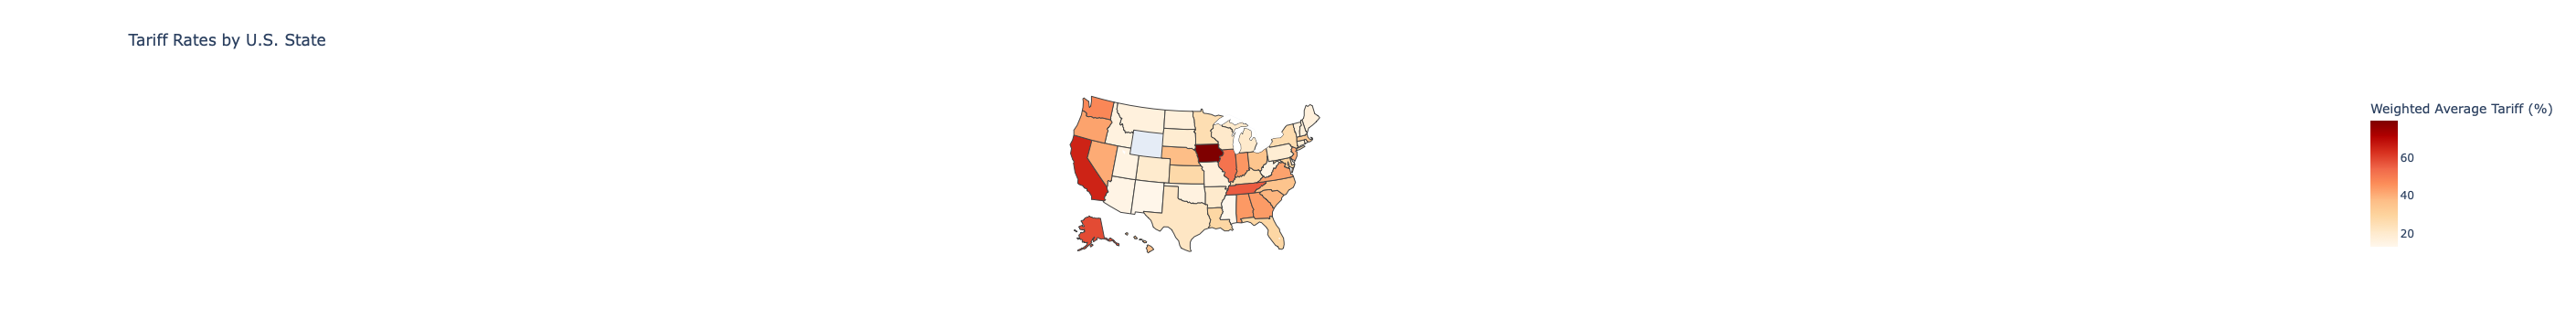

,STATE,Total_GEN_VAL_MO,Weighted Average Tariff (%),Share of Total Trade (%)
26,MS,3654241258,12.75,0.13
33,NM,18010615669,13.32,0.63
4,AZ,25792645676,14.26,0.90
52,WV,181541,14.56,0.00
46,UT,1271270293,15.18,0.04
37,OK,6955833072,15.51,0.24
14,ID,7935605112,15.78,0.28
9,DE,6134217731,15.82,0.21
27,MT,15850079751,16.18,0.55
22,ME,12090320916,16.55,0.42


In [83]:


# Example data – add your actual tariff rates here
data = {
    'State': ['NY', 'CA', 'TX', 'FL', 'IL', 'PA', 'OH', 'GA', 'NC', 'MI'],
    'Region': ['Northeast', 'West', 'South', 'South', 'Midwest', 'Northeast', 'Midwest', 'South', 'South', 'Midwest'],
    'TariffRate': [5.2, 3.9, 6.1, 6.1, 4.8, 5.2, 4.8, 6.1, 6.1, 4.8]
}

df = pd.DataFrame(data)

# Plotly choropleth map
fig = px.choropleth(
    weighted_avg_by_state,
    locations='STATE',
    locationmode='USA-states',  # Use 2-letter state abbreviations
    color='Weighted Average Tariff (%)',
    #hover_name='Region',
    scope='usa',
    color_continuous_scale='OrRd',
    title='Tariff Rates by U.S. State'
)

fig.show()
weighted_avg_by_state.round(2).to_csv('./Results/tariff_state.csv')
weighted_avg_by_state.round(2).sort_values('Weighted Average Tariff (%)')#.to_csv('temp.csv')

In [84]:
df = df_combined_metro_f

# Calculate weighted tariff
df['WEIGHTED_TARIFF'] = df['GEN_VAL_MO'] * df['TARIFF']

# Add a column with total GEN_VAL_MO for each region alongside the weighted average
weighted_avg_by_metro = df.groupby('CBSA_NAME').agg(
    Total_GEN_VAL_MO=('GEN_VAL_MO', 'sum'),
    Weighted_Tariff_Total=('WEIGHTED_TARIFF', 'sum')
).reset_index()


# Calculate the weighted average tariff
weighted_avg_by_metro['Weighted Average Tariff (%)'] = (
    weighted_avg_by_metro['Weighted_Tariff_Total'] / weighted_avg_by_metro['Total_GEN_VAL_MO']
)

# Drop intermediate calculation column
weighted_avg_by_metro = weighted_avg_by_metro.drop(columns='Weighted_Tariff_Total')

weighted_avg_by_metro.sort_values('Weighted Average Tariff (%)').to_csv('./Results/metro_tariffs.csv',index=False)
weighted_avg_by_metro.sort_values('Weighted Average Tariff (%)')





,CBSA_NAME,Total_GEN_VAL_MO,Weighted Average Tariff (%)
87,"Mayagüez, PR",7873433,10.000000
119,"Panama City, FL",3436934818,10.451531
128,"Port St. Lucie, FL",12785710,10.802957
154,"Shreveport-Bossier City, LA",157242628,11.900924
54,"Fresno, CA",12252724,11.902381
...,...,...,...
19,"Birmingham-Hoover, AL",613202172,89.979286
148,"San Luis Obispo-Paso Robles-Arroyo Grande, CA",5214547,92.717321
81,"Longview, WA",257492255,95.552353
158,"Springfield, MO",14891278,101.701625


In [94]:
twenty_largest = weighted_avg_by_metro.nlargest(20, 'Total_GEN_VAL_MO', keep='first').sort_values('Weighted Average Tariff (%)')
twenty_largest

,CBSA_NAME,Total_GEN_VAL_MO,Weighted Average Tariff (%)
78,"Laredo, TX",196316213566,13.384210
48,"El Paso, TX",76440472830,14.632831
144,"San Diego-Carlsbad, CA",46879977927,16.124845
122,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",44209110000,18.098849
25,"Buffalo-Cheektowaga-Niagara Falls, NY",46922971117,19.032954
127,"Port Huron, MI",67039072695,19.578840
44,"Detroit-Warren-Dearborn, MI",86451364220,20.757250
10,"Atlanta-Sandy Springs-Roswell, GA",45636284353,24.622815
104,"New Orleans-Metairie, LA",64329346776,29.179596
12,"Baltimore-Columbia-Towson, MD",52062328293,29.660406


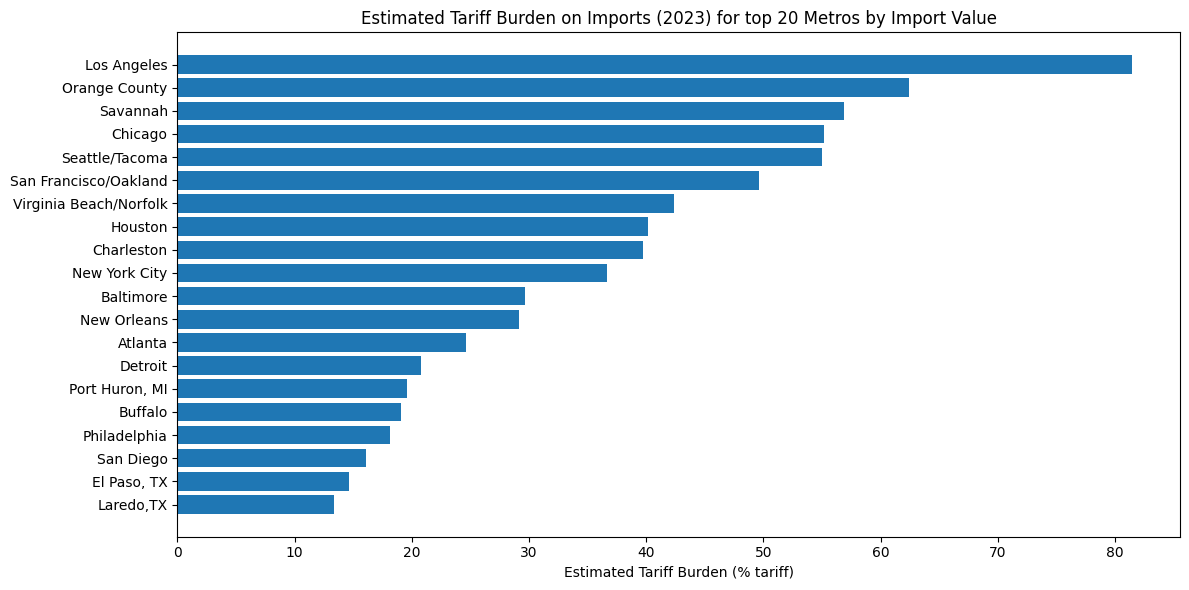

In [102]:

import matplotlib.pyplot as plt

# Sort by estimated burden
df_metro_tariff = twenty_largest.sort_values(by='Weighted Average Tariff (%)', ascending=False)

cbsa_rename_dict = {
    'Laredo, TX': 'Laredo,TX',
    'El Paso, TX': 'El Paso, TX',
    'San Diego-Carlsbad, CA': 'San Diego',
    'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD': 'Philadelphia',
    'Buffalo-Cheektowaga-Niagara Falls, NY': 'Buffalo',
    'Port Huron, MI': 'Port Huron, MI',
    'Detroit-Warren-Dearborn, MI': 'Detroit',
    'Atlanta-Sandy Springs-Roswell, GA': 'Atlanta',
    'New Orleans-Metairie, LA': 'New Orleans',
    'Baltimore-Columbia-Towson, MD': 'Baltimore',
    'New York-Newark-Jersey City, NY-NJ-PA': 'New York City',
    'Charleston-North Charleston, SC': 'Charleston',
    'Houston-The Woodlands-Sugar Land, TX': 'Houston',
    'Virginia Beach-Norfolk-Newport News, VA-NC': 'Virginia Beach/Norfolk',
    'San Francisco-Oakland-Hayward, CA': 'San Francisco/Oakland',
    'Seattle-Tacoma-Bellevue, WA': 'Seattle/Tacoma',
    'Chicago-Naperville-Elgin, IL-IN-WI': 'Chicago',
    'Savannah, GA': 'Savannah',
    'Santa Ana-Anaheim-Irvine, CA': 'Orange County',
    'Los Angeles-Long Beach-Anaheim, CA': 'Los Angeles'
}

df_metro_tariff['CBSA_NAME'] = df_metro_tariff['CBSA_NAME'].replace(cbsa_rename_dict)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(df_metro_tariff['CBSA_NAME'], df_metro_tariff['Weighted Average Tariff (%)'])
plt.xlabel('Estimated Tariff Burden (% tariff)')
plt.title('Estimated Tariff Burden on Imports (2023) for top 20 Metros by Import Value')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

['Laredo, TX',
 'El Paso, TX',
 'San Diego-Carlsbad, CA',
 'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD',
 'Buffalo-Cheektowaga-Niagara Falls, NY',
 'Port Huron, MI',
 'Detroit-Warren-Dearborn, MI',
 'Atlanta-Sandy Springs-Roswell, GA',
 'New Orleans-Metairie, LA',
 'Baltimore-Columbia-Towson, MD',
 'New York-Newark-Jersey City, NY-NJ-PA',
 'Charleston-North Charleston, SC',
 'Houston-The Woodlands-Sugar Land, TX',
 'Virginia Beach-Norfolk-Newport News, VA-NC',
 'San Francisco-Oakland-Hayward, CA',
 'Seattle-Tacoma-Bellevue, WA',
 'Chicago-Naperville-Elgin, IL-IN-WI',
 'Savannah, GA',
 'Santa Ana-Anaheim-Irvine, CA',
 'Los Angeles-Long Beach-Anaheim, CA']

## **Scratch Paper / Working Area**

This section is reserved for temporary calculations, tests, and exploratory code that support the main analysis.



In [31]:
df_combined_state_t = pd.merge(df_combined_state, df_tariff_merge, on="CTY_CODE", how="left")
df_combined_state_t[df_combined_state_t['TARIFF'].notna()].reset_index(drop=True)

df_combined_state_t[df_combined_state_t['STATE'] == 'IA'].dropna(subset=['Share of US Imports']).sort_values('GEN_VAL_MO')

,CTY_CODE,CTY_NAME,STATE,GEN_VAL_MO,Unnamed: 0,COUNTRY,Share of US Imports,TARIFF,Updated Total,ISOCODE
808,2010,MEXICO,IA,0,1.0,Mexico,0,25.0,10%,MX
5481,5880,JAPAN,IA,2024,4.0,Japan,4.5%,24.0,10%,JP
1831,3370,CHILE,IA,2045,48.0,Chile,<1%,10.0,10%,CL
3573,4751,SAN MARINO,IA,3114,146.0,San Marino,<1%,10.0,10%,SM
1973,3570,ARGENTINA,IA,8250,22.0,Argentina,<1%,10.0,10%,AR
1875,3510,BRAZIL,IA,35648,13.0,Brazil,1.3%,10.0,10%,BR
5586,6021,AUSTRALIA,IA,37800,25.0,Australia,<1%,10.0,10%,AU
4562,5330,INDIA,IA,86860,8.0,India,2.7%,26.0,10%,IN
5430,5830,TAIWAN,IA,137211,7.0,Taiwan,3.6%,32.0,10%,TW
699,1220,CANADA,IA,344529,0.0,Canada,0,25.0,10%,CA


In [ ]:
# Sample data for demonstration if needed
df_tariffs_sample = pd.DataFrame({
    "PORT_NAME": [
        "Los Angeles, CA", "New York, NY", "Houston, TX", "Savannah, GA", "Seattle, WA", "Sample, City, NY"
    ]
})

# Assume df contains a column named PORT_NAME with values like "City, State"
# Split the PORT_NAME into CITY and STATE
split_port = df_tariffs_sample['PORT_NAME'].str.split(',', n=1, expand=True)

# Handle cases with missing values
df_tariffs_sample['CITY'] = split_port[0].str.strip()
df_tariffs_sample['STATE'] = split_port[1].fillna('').str.strip()
df_tariffs_sample

In [248]:

df_tariffs_sample = pd.DataFrame({
    "PORT_NAME": [
        "Los Angeles, CA", "New York, NY", "Houston, TX", "Savannah, GA", "Seattle, WA", "Sample, City, NY"
    ]
})

split_port = df_tariffs_sample['PORT_NAME'].str.rsplit(',', n=1, expand=True)
df_tariffs_sample['CITY'] = split_port[0].str.strip()
df_tariffs_sample['STATE'] = split_port[1].fillna('').str.strip()

print(df_tariffs_sample)


          PORT_NAME          CITY STATE
0   Los Angeles, CA   Los Angeles    CA
1      New York, NY      New York    NY
2       Houston, TX       Houston    TX
3      Savannah, GA      Savannah    GA
4       Seattle, WA       Seattle    WA
5  Sample, City, NY  Sample, City    NY


In [163]:
df_combined_region_f
#df_combined_region_f["TARIFF"] = df_combined_region_f["TARIFF"].str.replace('%', '', regex=False).astype(float)
df_combined_metro_f[df_combined_metro_f['CTY_NAME'] == 'MEXICO']

,CTY_CODE,CTY_NAME,CBSA_NAME,CBSA_CODE,GEN_VAL_MO,Unnamed: 0,COUNTRY,Share of US Imports,TARIFF,Updated Total,ISOCODE,WEIGHTED_TARIFF


In [30]:
df_combined_metro_f.columns

Index(['CTY_CODE', 'CTY_NAME', 'CBSA_NAME', 'CBSA_CODE', 'GEN_VAL_MO',
       'Unnamed: 0', 'COUNTRY', 'Share of US Imports', 'TARIFF',
       'Updated Total', 'ISOCODE'],
      dtype='object')

In [46]:
df_combined[df_combined['CBSA_CODE']=='16980'].to_csv('temp.csv')

In [35]:
df_agg[df_agg['STATE']=='IA']

,CTY_CODE,CTY_NAME,PORT,PORT_NAME,GEN_VAL_MO,CITY,STATE
281,-,TOTAL FOR ALL COUNTRIES,3513,"DES MOINES, IA",18036569,DES MOINES,IA
592,0003,EUROPEAN UNION,3513,"DES MOINES, IA",8375362,DES MOINES,IA
905,0014,PACIFIC RIM COUNTRIES,3513,"DES MOINES, IA",8786115,DES MOINES,IA
1384,0020,USMCA (NAFTA),3513,"DES MOINES, IA",344529,DES MOINES,IA
1643,0021,TWENTY LATIN AMERICAN REPUBLICS,3513,"DES MOINES, IA",45943,DES MOINES,IA
1978,0022,OECD,3513,"DES MOINES, IA",9156406,DES MOINES,IA
2327,0023,NATO,3513,"DES MOINES, IA",8645004,DES MOINES,IA
2595,0024,LAFTA,3513,"DES MOINES, IA",45943,DES MOINES,IA
2879,0025,EURO AREA,3513,"DES MOINES, IA",8329056,DES MOINES,IA
3230,0026,APEC,3513,"DES MOINES, IA",9132689,DES MOINES,IA
